# Analyzing my Peloton workout data with Seaborn

## Importing Packages & Loading Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
from datetime import datetime
import warnings 
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/sejaldua/pelo-wolfpack/master/workout_data.csv', parse_dates=['timestamp'])
df

,timestamp,fitness_discipline,title,duration,instructor,calories,distance
0,2021-08-03 20:36:14+00:00,running,20 min HIIT Run,1200,Becs Gentry,219,2.28
1,2021-08-02 18:03:24+00:00,running,30 min J Balvin Run,1800,Robin Arzón,315,3.28
2,2021-08-01 15:44:11+00:00,running,45 min Endurance Run,2700,Becs Gentry,420,4.92
3,2021-07-30 17:12:49+00:00,running,30 min Tropical House Run,1800,Selena Samuela,334,3.28
4,2021-07-29 13:21:49+00:00,running,30 min Intervals Run,1800,Becs Gentry,346,3.39
...,...,...,...,...,...,...,...
195,2018-05-10 19:25:23+00:00,cycling,30 min Low Impact Ride,1800,Christine D'Ercole,133,6.35
196,2018-01-05 22:21:48+00:00,cycling,20 min Beginner Ride,1200,Christine D'Ercole,75,3.85
197,2017-12-31 21:43:27+00:00,cycling,30 min Advanced Beginner Ride,1800,Christine D'Ercole,122,6.02
198,2017-12-28 23:38:11+00:00,cycling,30 min Intervals & Arms Ride,1800,Christine D'Ercole,106,5.21


## Data Cleaning & Wrangling

In [3]:
# convert duration from seconds to minutes
df['duration'] = df['duration'].apply(lambda x: x // 60)

In [4]:
# creating new datetime-based features
df['timestamp'] = df['timestamp'].apply(lambda x: pd.to_datetime(x).tz_convert('US/Eastern'))
df['year'] = df.timestamp.dt.year
df['month'] = df.timestamp.dt.month
df['hour'] = df.timestamp.dt.hour
df['weekday'] = df.timestamp.dt.day_name()
df['week_num'] = df['timestamp'].apply(lambda x: x.isocalendar()[1] % 52)
df[['timestamp'] + list(df.columns[-5:].values)].head(n=1)

,timestamp,year,month,hour,weekday,week_num
0,2021-08-03 16:36:14-04:00,2021,8,16,Tuesday,31


In [5]:
# get weekday_num in order of MTWTFSS because we want to sort the rows of the heatmap in order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
mapping = {k: v for k, v in zip(weekday_order, [i+1 for i in range(7)])}
df['weekday_num'] = df['weekday'].apply(lambda x: mapping[x])

In [6]:
# let's also save a variable of month abbreviations for tick labeling purposes later
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug']

In [7]:
# filter out 'Just Run' because only interested in Peloton on-demand classes
df = df[~df.title.str.contains('Just Run')]
df = df[df['fitness_discipline'] == 'running']

# strip the first part of the titles, which indicates the duration (e.g. '45 min ...')
run_titles = list(df['title'])
run_titles = [x[7:] if int(x[:2]) else x for x in run_titles]

# inspect the unique types of runs in the dataset
print(set(run_titles))

{'R&B Run', 'Latin Run', 'Warm Up Run', 'Progression Run', 'Long Run Warm Up', 'asics: Striders', 'Tempo Run', 'Recovery Run', 'J Balvin Run', 'Beyoncé Run', 'Endurance Run', 'Tropical House Run', '2010s Hip Hop Run', 'Pop Fun Run', 'House Run', 'Pop Run', 'Rock Run', 'Cool Down Run', '2010s Run', 'EDM Run', 'Intervals Run', 'The Weeknd Run', 'HIIT & Hills Run', 'HIIT Run', 'Extra Mile', 'Pop Punk Run', 'Breakthrough Run', 'Hip Hop Run'}


In [8]:
# devise a mapping strategy to partition runs into categories
def get_run_type(x):
    types = ['Endurance', 'Intervals', 'HIIT & Hills', 'HIIT', 'Tempo', 'Progression']
    for run_type in types:
        if run_type in x:
            return run_type
        elif 'Breakthrough' in x:
            return 'Progression'
        elif any([keyword in x for keyword in ['Warm Up', 'Cool Down', 'Extra Mile', 'Recovery']]):
            return 'Warm Up / Cool Down'
        
    # there are many runs based on musical genre (Beyonce, J Balvin, Hip Hop, EDM, ...)
    # serves as a catch-all if no specific training category applies
    return "Musical Genre"

df['run_type'] = df['title'].apply(lambda x: get_run_type(x))

In [9]:
# filter dataset to only look at 2021 data
data_2021 = df[df['year'] == 2021]
data_2021.tail(n=3)

,timestamp,fitness_discipline,title,duration,instructor,calories,distance,year,month,hour,weekday,week_num,weekday_num,run_type
119,2021-01-05 13:57:53-05:00,running,30 min 2010s Run,30,Andy Speer,318,3.36,2021,1,13,Tuesday,1,2,Musical Genre
120,2021-01-04 12:53:34-05:00,running,30 min HIIT Run,30,Robin Arzón,310,3.27,2021,1,12,Monday,1,1,HIIT
123,2021-01-01 15:34:43-05:00,running,45 min Hip Hop Run,45,Adrian Williams,467,4.93,2021,1,15,Friday,1,5,Musical Genre


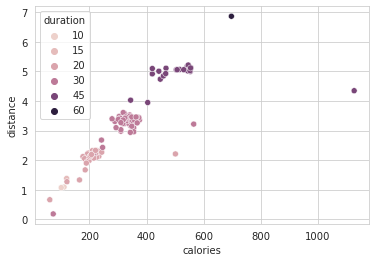

In [10]:
sns.scatterplot(data=data_2021, x='calories', y='distance', hue='duration');

In [11]:
# remove those 3 outliers due to wearable tech glitches
print("Prev dataframe size:", len(data_2021))
temp_df = data_2021.copy()
temp_df['cal/dist'] = data_2021['calories'] / data_2021['distance']
temp_df.sort_values(by='cal/dist', ascending=False, inplace=True)
temp_df.head()

Prev dataframe size: 119


,timestamp,fitness_discipline,title,duration,instructor,calories,distance,year,month,hour,weekday,week_num,weekday_num,run_type,cal/dist
11,2021-07-11 13:28:00-04:00,running,30 min Progression Run,30,Becs Gentry,73,0.18,2021,7,13,Sunday,27,7,Progression,405.555556
94,2021-02-04 13:40:25-05:00,running,45 min Rock Run,45,Rebecca Kennedy,1127,4.35,2021,2,13,Thursday,5,4,Musical Genre,259.080460
93,2021-02-05 09:45:35-05:00,running,20 min House Run,20,Olivia Amato,501,2.21,2021,2,9,Friday,5,5,Musical Genre,226.696833
92,2021-02-06 11:20:28-05:00,running,30 min Pop Run,30,Jess Sims,565,3.22,2021,2,11,Saturday,5,6,Musical Genre,175.465839
95,2021-02-03 12:25:54-05:00,running,20 min Intervals Run,20,Olivia Amato,165,1.33,2021,2,12,Wednesday,5,3,Intervals,124.060150


In [12]:
data_2021 = temp_df.iloc[4:,:]
print("New dataframe size:", len(data_2021))
data_2021.sort_values(by='timestamp', ascending=False, inplace=True)

New dataframe size: 115


# Seaborn Visualizations

### QUANTITATIVE DATA: Workout Metrics (distance, calories)

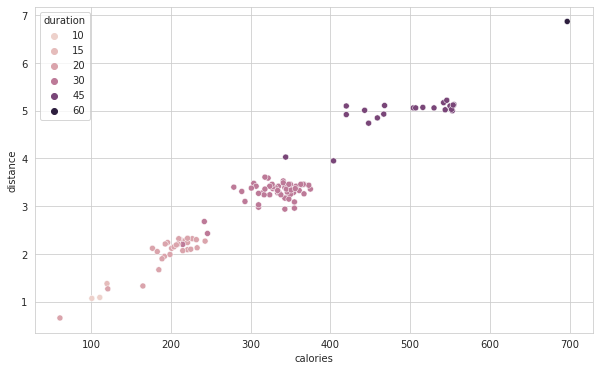

In [53]:
fig = plt.figure(figsize=(10,6));
ax = sns.scatterplot(data=data_2021, x='calories', y='distance', hue='duration');
fig.savefig('dist_vs_calories.png')

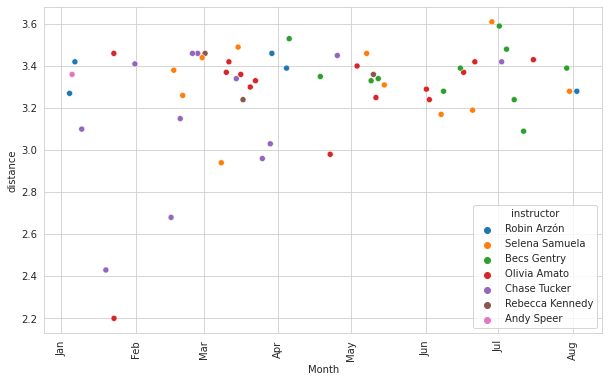

In [56]:
fig = plt.figure(figsize=(10,6));
ax = sns.scatterplot(data=data_2021[data_2021['duration'] == 30], x='timestamp', y='distance', hue='instructor');
ax.set_xticklabels(month_order, rotation=90);
plt.xlabel('Month');
fig.savefig('30min_distance_over_time.png')

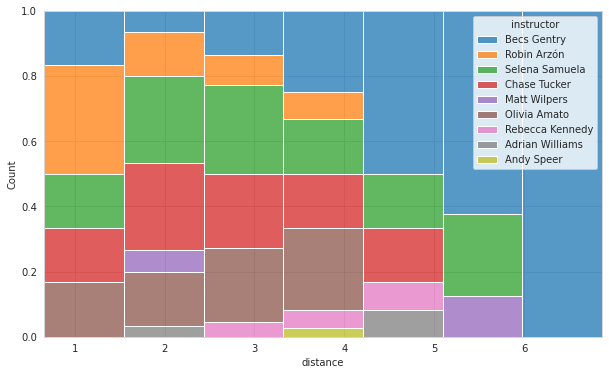

In [63]:
fig = plt.figure(figsize=(10,6));
sns.histplot(data=data_2021, x='distance', hue='instructor', multiple='fill', bins=7);
fig.savefig('hist_distance_fill.png')

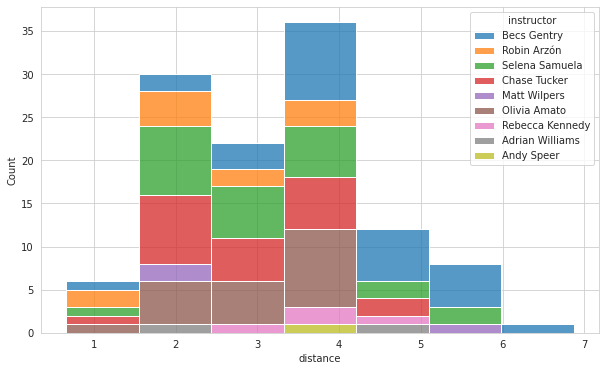

In [64]:
fig = plt.figure(figsize=(10,6));
sns.histplot(data=data_2021, x='distance', hue='instructor', multiple='stack', bins=7);
fig.savefig('hist_distance_stack.png')

### CATEGORICAL DATA: analyzing class frequency (instructor, run type)

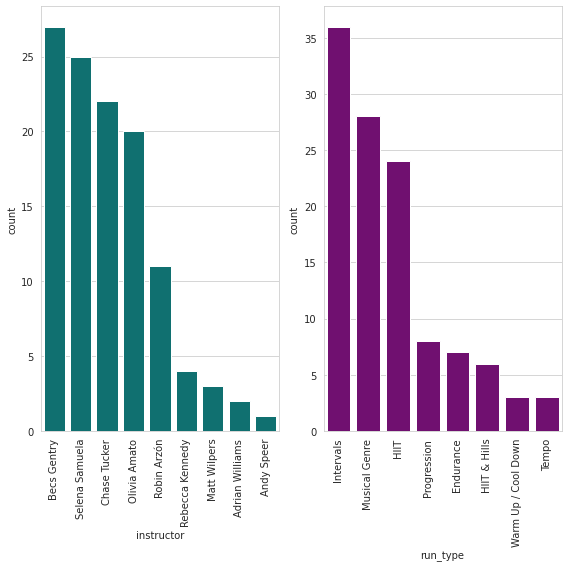

In [68]:
fig, ax = plt.subplots(1,2,figsize=(8,8));
sns.countplot(data=data_2021, x='instructor', 
                   order=data_2021['instructor'].value_counts().index,
                   color='teal', ax=ax[0]);
sns.countplot(data=data_2021, x='run_type', 
                   order=data_2021['run_type'].value_counts().index,
                   color='purple', ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90);
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90);
plt.tight_layout();
fig.savefig('class_frequency_by_cat_vars.png')

<Figure size 576x576 with 0 Axes>

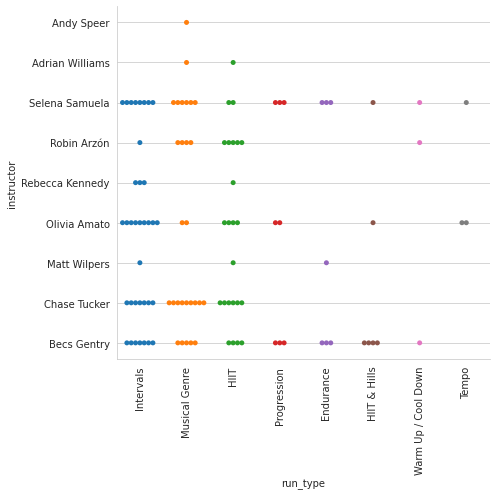

In [98]:
fig = plt.figure(figsize=(8,8));
sns.catplot(data=data_2021, x='run_type', y='instructor', size=7, kind='swarm',
                   order=list(data_2021['run_type'].value_counts().index));
plt.xticks(rotation=90);
plt.tight_layout();
fig.savefig('instructor_vs_run_type_catplot.png');

<Figure size 576x576 with 0 Axes>

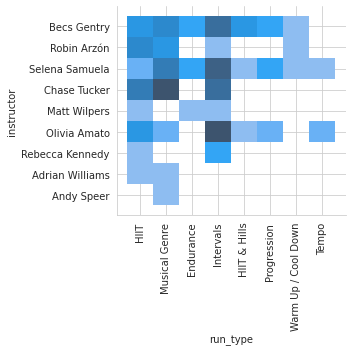

In [97]:
fig = plt.figure(figsize=(8,8));
sns.displot(data=data_2021, x='run_type', y='instructor');
plt.xticks(rotation=90);
plt.tight_layout();
fig.savefig('instructor_vs_run_type_displot.png');

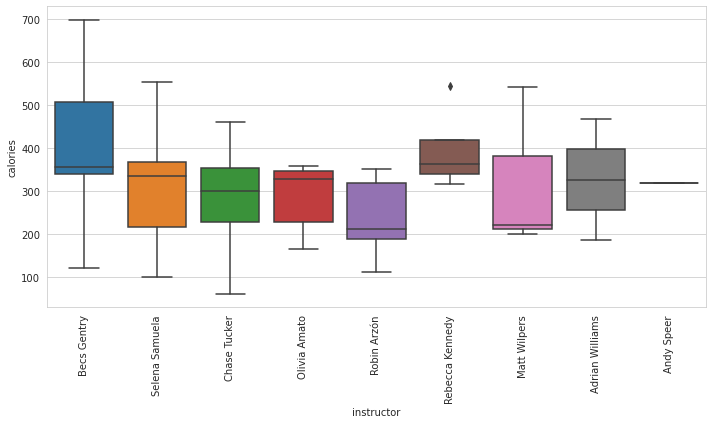

In [96]:
fig = plt.figure(figsize=(10,6));
sns.boxplot(data=data_2021, x='instructor', y='calories',
                   order=data_2021['instructor'].value_counts().index);
plt.xticks(rotation=90);
plt.tight_layout();
fig.savefig('calories_vs_instructor_boxplot.png');

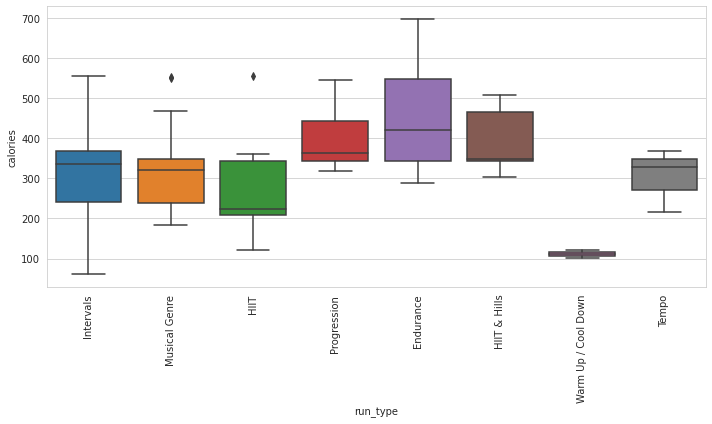

In [95]:
fig = plt.figure(figsize=(10,6));
ax = sns.boxplot(data=data_2021, x='run_type', y='calories',
                   order=data_2021['run_type'].value_counts().index);
plt.xticks(rotation=90);
plt.tight_layout();
fig.savefig('calories_vs_run_type_boxplot.png');

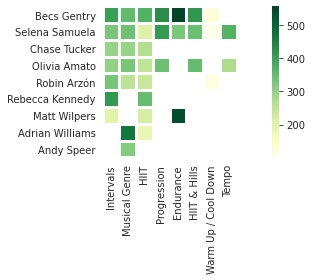

In [94]:
fig = plt.figure(figsize=(10,4));
df_pivoted = pd.pivot_table(data_2021[['run_type', 'instructor', 'calories']], 
                           values='calories', index=['instructor'], 
                           columns=['run_type'], aggfunc=np.mean)
df_pivoted = df_pivoted.reindex(list(data_2021['instructor'].value_counts().index))
df_pivoted = df_pivoted.reindex(list(data_2021['run_type'].value_counts().index), axis=1)
sns.heatmap(df_pivoted, cmap='YlGn', square=True, linewidths=3);
plt.ylabel("");
plt.xlabel("");
plt.tight_layout();
fig.savefig('instructor_run_type_cal_heatmap.png')


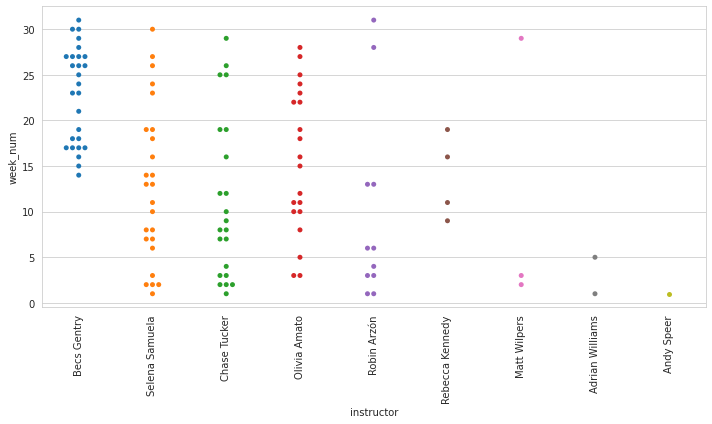

In [93]:
fig = plt.figure(figsize=(10,6));
ax = sns.swarmplot(data=data_2021, y='week_num', x='instructor', 
                  order=data_2021['instructor'].value_counts().index);
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.tight_layout();
fig.savefig('instructors_over_time_swarmplot.png')

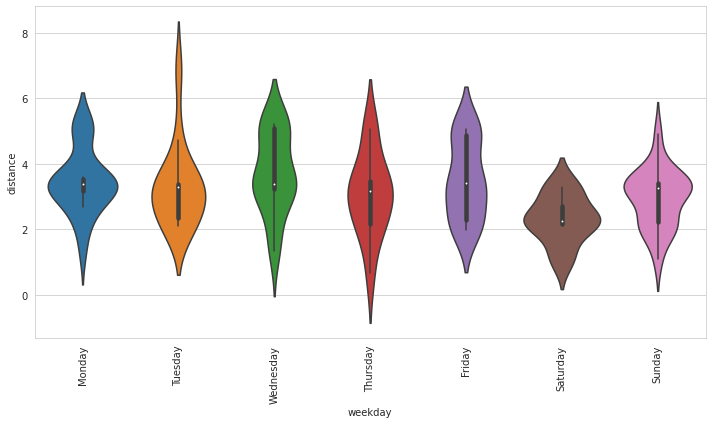

In [92]:
fig = plt.figure(figsize=(10,6));
ax = sns.violinplot(data=data_2021, x='weekday', y='distance', order=weekday_order);
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
plt.tight_layout();
fig.savefig('distance_vs_weekday_violinplot.png')

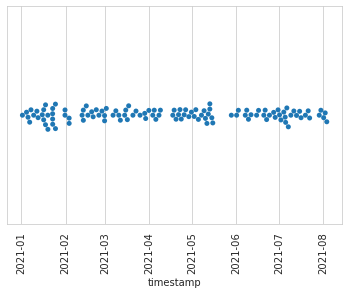

In [78]:
ax = sns.swarmplot(x=data_2021['timestamp']);
plt.xticks(rotation=90);

In [79]:
df_to_pivot = data_2021[['week_num', 'weekday_num', 'distance']]
pivoted_data = pd.pivot_table(df_to_pivot, values='distance', index=['weekday_num'], columns=['week_num'], aggfunc=np.mean)
pivoted_data = pivoted_data.reindex([i+1 for i in range(max(pivoted_data.columns))], axis=1)
pivoted_data

week_num,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
weekday_num,,,,,,,,,,,,,,,,,,,,,
1,3.27,2.33,NaN,NaN,NaN,NaN,2.68,5.12,3.46,2.94,...,NaN,3.17,NaN,3.42,3.61,1.81,NaN,5.06,NaN,3.28
2,3.36,2.21,3.585,NaN,NaN,NaN,3.38,NaN,NaN,NaN,...,3.29,3.28,3.39,2.32,NaN,2.09,6.87,NaN,NaN,2.28
3,3.42,NaN,NaN,NaN,1.5,NaN,NaN,3.46,NaN,3.37,...,3.24,2.28,3.37,NaN,5.11,3.24,NaN,5.17,NaN,NaN
4,2.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.42,...,NaN,NaN,NaN,5.07,3.59,NaN,3.43,0.66,3.39,NaN
5,4.93,4.85,2.430,NaN,NaN,2.050,3.15,3.46,NaN,NaN,...,NaN,5.06,NaN,NaN,3.42,2.25,2.30,NaN,3.28,NaN
6,3.10,1.61,NaN,NaN,NaN,1.795,3.26,NaN,2.27,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,2.01,2.095,2.25,NaN,NaN,NaN,2.86,NaN,3.34,...,NaN,NaN,3.19,2.13,3.48,3.09,NaN,NaN,4.92,NaN


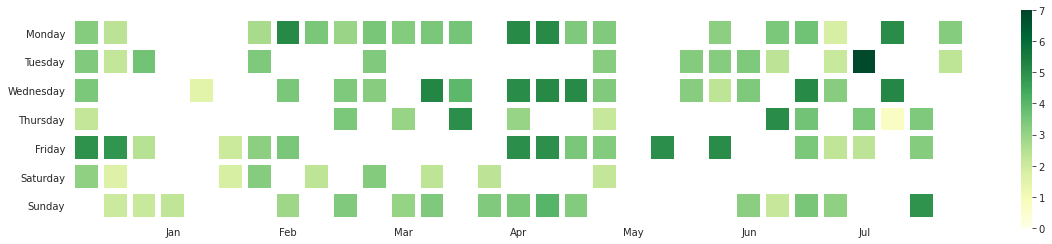

In [80]:
fig = plt.figure(figsize=(20,4));
space = [" ", " ", " "]
sns.heatmap(pivoted_data, linewidths=6, vmin=0, vmax=7, cmap='YlGn', cbar=True,
                 linecolor='white', square=True, yticklabels=weekday_order, 
            xticklabels=[*space, 'Jan', *space, 'Feb', *space, 'Mar', *space, 'Apr', 
                         *space, 'May', *space, 'Jun', *space, 'Jul']);
plt.ylabel("");
plt.xlabel("");
fig.savefig('github_style_distance_heatmap_calendar.png')

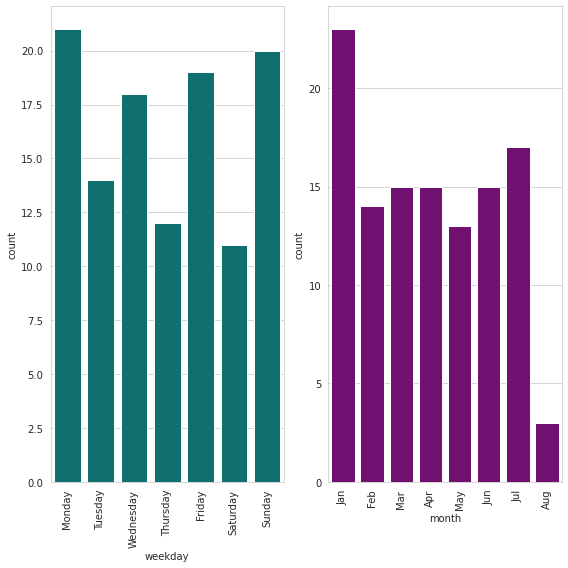

In [81]:
fig, ax = plt.subplots(1,2,figsize=(8,8));
sns.countplot(data=data_2021, x='weekday', order=weekday_order, color='teal', ax=ax[0]);
sns.countplot(data=data_2021, x='month', color='purple',
                   order=[i+1 for i in range(max(data_2021['month']))], ax=ax[1]);
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90);
ax[1].set_xticklabels(month_order, rotation=90);
plt.tight_layout();
fig.savefig('class_frequency_vs_time_increments.png')

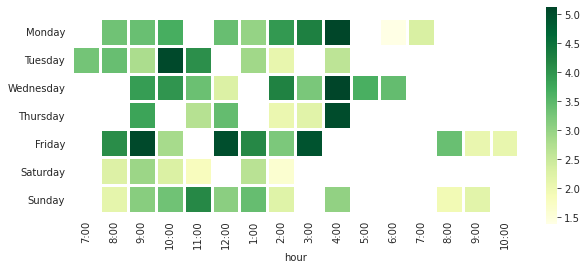

In [82]:
fig = plt.figure(figsize=(10,4));
df_pivoted = pd.pivot_table(data_2021[['weekday_num', 'hour', 'distance']], 
                           values='distance', index=['weekday_num'], 
                           columns=['hour'], aggfunc=np.mean)
sns.heatmap(df_pivoted, cmap='YlGn', yticklabels=weekday_order, square=True, linewidths=3,
            xticklabels = [str(x % 12) + ":00" if x != 12 else "12:00" for x in df_pivoted.columns]);
plt.ylabel("");
fig.savefig('weekday_vs_time_vs_dist_heatmap.png')

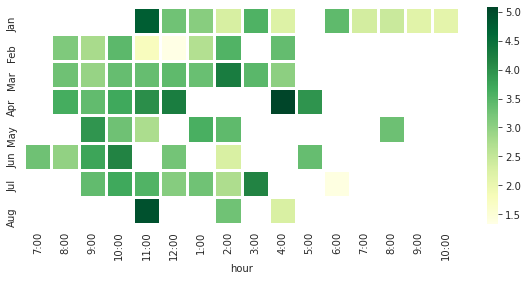

In [83]:
fig = plt.figure(figsize=(10,4));
df_pivoted = pd.pivot_table(data_2021[['month', 'hour', 'distance']], 
                           values='distance', index=['month'], 
                           columns=['hour'], aggfunc=np.mean)
sns.heatmap(df_pivoted, cmap='YlGn', square=True, linewidths=3,
            yticklabels=month_order, 
            xticklabels = [str(x % 12) + ":00" if x != 12 else "12:00" for x in df_pivoted.columns]);
plt.ylabel("");
fig.savefig('month_vs_time_vs_dist_heatmap.png')

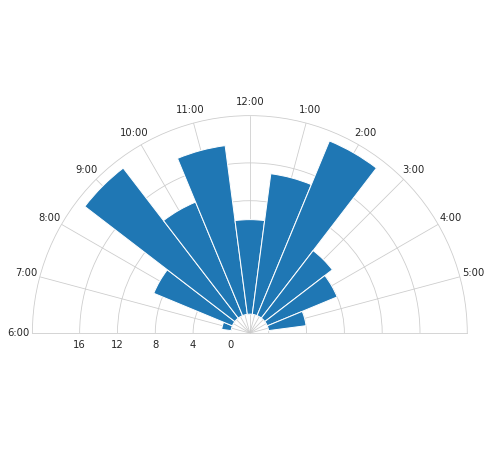

In [84]:
arr = list(df['hour'])
N = 12
bottom = 2

# create theta for 12 hours
theta = np.linspace(0.0, np.pi, N, endpoint=False)

# make the histogram that bined on 24 hour
_, tick = np.histogram(arr, bins = N)
radii = df['hour'].value_counts().sort_index().reindex([i+1 for i in range(5, 5+N)]).fillna(0)

# width of each bin on the plot
width = (np.pi) / N

# make a polar plot
fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# set the lable go clockwise and start from the left-hand side (West)
ax.set_theta_zero_location("W")
ax.set_theta_direction(-1) # clockwise

# we just want half of the polar chart
ax.set_thetamin(0)
ax.set_thetamax(180)

# setting xticks and xticklabels
ax.set_xticks(np.pi/180 * np.linspace(0, 180, N, endpoint=False))
ticks = [str(x % 12) + ":00" if x != 12 else "12:00" for x in radii.index]
ax.set_xticklabels(ticks);
ax.set_rgrids([4*i + 2 for i in range(5)], labels=[str(x-2) for x in [4*i + 2 for i in range(5)]])

fig.savefig('polar_chart_run_time_freq.png')
plt.show()

## Finished!

In [ ]:
# commit to jovian
message = input("Enter a commit message: ")
jovian.commit(message=message, outputs=['dist_vs_calories.png',
                                        '30min_distance_over_time.png',
                                        'hist_distance_fill.png',
                                        'hist_distance_stack.png',
                                        'class_frequency_by_cat_vars.png',
                                        'instructor_vs_run_type_catplot.png',
                                        'instructor_vs_run_type_displot.png',
                                        'calories_vs_instructor_boxplot.png',
                                        'calories_vs_run_type_boxplot.png',
                                        'instructor_run_type_cal_heatmap.png',
                                        'instructors_over_time_swarmplot.png',
                                        'distance_vs_weekday_violinplot.png',
                                        'github_style_distance_heatmap_calendar.png',
                                        'class_frequency_vs_time_increments.png',
                                        'weekday_vs_time_vs_dist_heatmap.png',
                                        'month_vs_time_vs_dist_heatmap.png',
                                        'polar_chart_run_time_freq.png'
                                       ])

Enter a commit message: apply tight layout


<IPython.core.display.Javascript object>